In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter


In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

--2026-01-21 20:30:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  12.8MB/s    in 14s     

2026-01-21 20:30:23 (11.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
def load_batch(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data[b'data'], np.array(data[b'labels'])

In [5]:
def load_all_training_batches(data_dir):
    X_list, y_list = [], []
    for i in range(1, 6):
        X, y = load_batch(f"{data_dir}/data_batch_{i}")
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

In [6]:
DATA_DIR = "cifar-10-batches-py"

X_train, y_train = load_all_training_batches(DATA_DIR)
X_test, y_test   = load_batch(f"{DATA_DIR}/test_batch")


In [7]:
X_train = X_train / 255.0
X_test  = X_test / 255.0


In [8]:
np.random.seed(42)

train_subset = 5000   # reasonable for KNN
test_subset  = 500

train_idx = np.random.choice(len(X_train), train_subset, replace=False)
test_idx  = np.random.choice(len(X_test), test_subset, replace=False)

X_train = X_train[train_idx]
y_train = y_train[train_idx]

X_test  = X_test[test_idx]
y_test  = y_test[test_idx]


In [9]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def minkowski(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

def cosine(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def hamming(a, b):
    return np.sum(a != b)


In [10]:
distance_metrics = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}


In [11]:
class KNN:
    def __init__(self, k, distance_func):
        self.k = k
        self.distance_func = distance_func

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict_one(self, x):
        distances = []
        for i in range(len(self.X)):
            d = self.distance_func(x, self.X[i])
            distances.append((d, self.y[i]))

        distances.sort(key=lambda t: t[0])
        neighbors = distances[:self.k]

        labels = [label for _, label in neighbors]
        return Counter(labels).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


In [12]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm


In [13]:
K_values = [1, 3, 5, 7, 9]
results = {}

for name, dist_func in distance_metrics.items():
    accs = []
    for k in K_values:
        model = KNN(k, dist_func)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accs.append(accuracy(y_test, preds))
    results[name] = accs


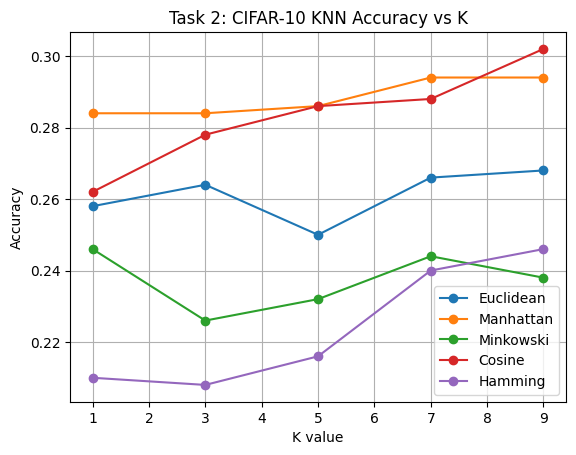

In [14]:
for name, accs in results.items():
    plt.plot(K_values, accs, marker='o', label=name)

plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("Task 2: CIFAR-10 KNN Accuracy vs K")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
best_k = 9
best_distance = cosine

best_model = KNN(best_k, best_distance)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy(y_test, y_pred))

Confusion Matrix:
 [[22  0  2  0  2  0  1  0 11  0]
 [ 9  5  2  5  3  4  2  1 22  3]
 [13  0 16  1 16  6  5  0  7  0]
 [ 6  1  4 12  2 12  4  1  5  1]
 [ 4  0 10  1 23  5  2  1  5  0]
 [ 5  1  9 10 10 16  2  0  4  0]
 [ 7  0  9  1 12  4  9  0  5  0]
 [ 1  1  4  6  7  6  3 10  7  0]
 [ 9  0  0  0  0  2  0  0 28  0]
 [ 2  3  2  4  4  1  5  1 23 10]]
Accuracy: 0.302
